In [1]:
LOAD_NAME = 'rad5cds_local.max.ds2to11_adaptive_wd0.1.pth'
# LOAD_NAME = 'rad5cds_local.max_adaptive.pth'


# reads_dataset_name = "hsa.dRNASeq.HeLa.polyA.REL5.long.1"
# reads_dataset_name = "hsa.dRNASeq.HeLa.polyA.REL5.long.2"
reads_dataset_name = "hsa_dRNA_HeLa_NoArs_polyA_5P_1"
# reads_dataset_name = "ds1ds2"

# reads_dataset_preprocessing = 'cds_local.max2/adaptive'
# reads_dataset_preprocessing = 'cds_local.max/adaptive'
reads_dataset_preprocessing = 'adaptive/adaptive'
# reads_dataset_preprocessing = 'original'

log_number = 9

GENERATE_NEW= True

LOG_OUTPUT_LOCATION = "results_logs/{}_trained_{}_tested_{}.txt".format(LOAD_NAME, reads_dataset_preprocessing.replace('/', '.'), log_number)

In [2]:
dataset_save_name = reads_dataset_name + reads_dataset_preprocessing + "_test"

In [3]:
import comet_ml
from torch import cuda
cuda.is_available()

/home/jovyan/my-conda-envs/decay_exploration/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [4]:
import sys
import argparse
import datetime
import numpy as np
from Bio import SeqIO
from math import ceil

from sklearn.model_selection import train_test_split

from raw_to_input import *
from raw_to_input import reformat, parse_data, parse_neg


def load_data(upstream5p, downstream3p, within, rbpfile, negfile, rep, onehot):
    """Parses and processes data from input FASTA and BED files and returns it in train and testing portions.
    @param upstream5p
    """
    rbp_dict = get_rbp_dict(rbpfile)

    x, rbps, y = [], [], []
    # Iterate through files and append sequences and corresponding labels and region information to above data arrays
    parse_data(upstream5p, x, y, rbps, rbp_dict, 5, rep, onehot)
    print(len(y), ' upstream5p; ', 'label balance: ', y.count(1), ' ones, ', y.count(0), ' zeros')
    parse_data(downstream3p, x, y, rbps, rbp_dict, 3, rep, onehot)
    print(len(y), ' downstream3p; ', 'label balance: ', y.count(1), ' ones, ', y.count(0), ' zeros')
    parse_data(within, x, y, rbps, rbp_dict, "w", rep, onehot)
    print(len(y), ' within; ', 'label balance: ', y.count(1), ' ones, ', y.count(0), ' zeros')

    x_neg, rbps_neg, y_neg = [], [], []
    
    while y.count(1) > y_neg.count(0):
        parse_neg(negfile, x_neg, y_neg, rbps_neg, rbp_dict, rep, onehot)
        print(len(y_neg), ' negfile; ', 'label balance: ', y.count(1), ' ones, ', y_neg.count(0), ' zeros')
    
    x.extend(x_neg[:len(y)])    
    rbps.extend(rbps_neg[:len(y)])  
    y.extend(y_neg[:len(y)])
    print(len(y), ' total; ', 'label balance: ', y.count(1), ' ones, ', y.count(0), ' zeros')
    
    
    return x, rbps, y

2023-10-13 14:16:36.102530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
home_path = '/home/jovyan'
pos_5p_train = home_path + '/decay/decay/get_fasta/results/{}/{}/decay_seqs_fasta/upstream-5P-end-transcripts_fasta_train.fa'.format(reads_dataset_name, reads_dataset_preprocessing)
pos_5p_test = home_path + '/decay/decay/get_fasta/results/{}/{}/decay_seqs_fasta/upstream-5P-end-transcripts_fasta_test.fa'.format(reads_dataset_name, reads_dataset_preprocessing)

pos_3p_train = home_path + '/decay/decay/get_fasta/results/{}/{}/decay_seqs_fasta/downstream-3P-end-transcripts_fasta_train.fa'.format(reads_dataset_name, reads_dataset_preprocessing)
pos_3p_test = home_path + '/decay/decay/get_fasta/results/{}/{}/decay_seqs_fasta/downstream-3P-end-transcripts_fasta_test.fa'.format(reads_dataset_name, reads_dataset_preprocessing)

within_train = home_path + '/decay/decay/get_fasta/results/{}/{}/decay_seqs_fasta/within_transcripts_fasta_train.fa'.format(reads_dataset_name, reads_dataset_preprocessing)
within_test = home_path + '/decay/decay/get_fasta/results/{}/{}/decay_seqs_fasta/within_transcripts_fasta_test.fa'.format(reads_dataset_name, reads_dataset_preprocessing)

neg_file = home_path + '/decay/decay/data/hg38/transcripts.fa'

rbp_file = home_path + '/decay/decay/rbp_data/AATF.bed'

rep = False # was True --- switch for soft-masked and hard-masked nucleotides 
onehot = False # Return nucleotide characters or one-hot vectors


In [6]:
pos_5p_test

'/home/jovyan/decay/decay/get_fasta/results/hsa_dRNA_HeLa_NoArs_polyA_5P_1/adaptive/adaptive/decay_seqs_fasta/upstream-5P-end-transcripts_fasta_test.fa'

In [7]:
import os

# if not os.path.exists(dataset_save_name):
if True:
    # Load test data
    x_test, rbps_test, y_test = load_data(
        pos_5p_test, pos_3p_test, within_test, 
        rbp_file, neg_file, rep, onehot)

737  upstream5p;  label balance:  737  ones,  0  zeros
740  downstream3p;  label balance:  740  ones,  0  zeros
16339  within;  label balance:  16339  ones,  0  zeros
67606  negfile;  label balance:  16339  ones,  67606  zeros
32678  total;  label balance:  16339  ones,  16339  zeros


In [8]:
if not os.path.exists(dataset_save_name):
    if onehot:
        n_seqlength, n_features = x_test[0].shape[0], x_test[0].shape[1]
        n_seqlength, n_features
    n_seqlength, n_features = np.shape(x_test)[0], np.shape(x_test)[1]
    n_seqlength, n_features


# Model and training

In [9]:

### Parameters

MODEL_NAME = "simecek/DNADebertaK6c"
TOKENIZER_NAME = "armheb/DNA_bert_6"
K = 6
STRIDE = 1

SEED=42
np.random.seed(SEED)

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, trust_remote_code=True)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.


## Nucleotide masking

In [11]:
from datasets import Dataset, DatasetDict


hard_nucleotide_masking = False
if not hard_nucleotide_masking:
#     hack to unmask nucleotides
    x_test = np.char.upper(x_test)
else:
    # no action needed, the tokenizer will map lower case chars to UNK tokens
    pass

def kmers_strideK(s, k=K):
    return [s[i:i + k] for i in range(0, len(s), k) if i + k <= len(s)]

def kmers_stride1(s, k=K):
    return [s[i:i + k] for i in range(0, len(s)-k+1)]

if (STRIDE == 1):
    kmers = kmers_stride1
else:
    kmers = kmers_strideK

# function used for the actual tokenization
if(K is not None):
    def tok_func(x): return tokenizer(" ".join(kmers(x["seq"])), truncation=True)
else:
    def tok_func(x): return tokenizer(x["seq"], truncation=True)


tmp_dict_test = {}
# TEST
for index, (x, y) in enumerate(zip(x_test, y_test)):
    tmp_dict_test[f"{index}"] = ("test", y, x)

df_test = pd.DataFrame.from_dict(tmp_dict_test).T.rename(columns = {0: "dset", 1: "cat", 2: "seq"})

df_test['seq'] = [''.join(map(str, l)) for l in df_test['seq']]


# def tokenize_to_ds(ds_test):
#     ds_test = Dataset.from_pandas(df_test)
    
#     tok_ds_test = ds_test.map(tok_func, batched=False, remove_columns=['__index_level_0__', 'seq'])
#     tok_ds_test = tok_ds_test.rename_columns({'cat':'labels'})

#     dds = DatasetDict({
#         # 'train': [],
#         # 'valid': [],
#         'test': tok_ds_test
#     })
#     return dds

In [12]:
def tokenize(batch):
    tokenized = [tokenizer(" ".join(kmers(x)), truncation=True) for x in batch]
    grouped = {
        'input_ids':[],
        'attention_mask':[],
    }
    for seq_dict in tokenized:
        for key, seq in seq_dict.items():
            if key in ['input_ids', 'attention_mask']:
                grouped[key].append(seq)
    
    return grouped
    
    
    # ds_test = Dataset.from_pandas(df_test)
    
    # tok_ds_test = ds_test.map(tok_func, batched=False, remove_columns=['__index_level_0__', 'seq'])
    # tok_ds_test = tok_ds_test.rename_columns({'cat':'labels'})

    # dds = DatasetDict({
    #     # 'train': [],
    #     # 'valid': [],
    #     'test': tok_ds_test
    # })
    # return dds

In [13]:
df_test['seq'][0]

'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCCGCCGCCGCCCGCCTCAGCCCAACATGGCGATGCACAACAAGGCGGCGCCGCCGCAGATCCCGGACACCCGGCGGGAGCTGGCGGAGCTCGTGAAGCGGAAGCAGGAGCTGGCGGAAACATTGGC'

In [14]:
df_test_examples = df_test['seq'][48:50]

In [15]:
def generate_mutations(sequence):
    """
    Generate all possible sequences with a single mutation.
    The alphabet is A, C, T, G. Do not mutate the N characters nor mutate any characters to N.
    """
    alphabet = ['A', 'C', 'T', 'G']
    mutations = [sequence]
    
    for i, char in enumerate(sequence):
        if char != 'N':
            for letter in alphabet:
                if letter != char:
                    mutated_seq = sequence[:i] + letter + sequence[i+1:]
                    mutations.append(mutated_seq)
    
    return pd.DataFrame(mutations, columns=['seq'])

# Testing the function with a sample sequence
mutated_df = generate_mutations(df_test_examples[0])
mutated_df[:10]

,seq
0,NNNNNNNNCCGGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...
1,NNNNNNNNACGGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...
2,NNNNNNNNTCGGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...
3,NNNNNNNNGCGGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...
4,NNNNNNNNCAGGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...
5,NNNNNNNNCTGGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...
6,NNNNNNNNCGGGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...
7,NNNNNNNNCCAGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...
8,NNNNNNNNCCCGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...
9,NNNNNNNNCCTGAACCTTGGGCGCGCGGAACCTCGGTGCCGGAGCG...


In [16]:
tokenize(mutated_df)

{'input_ids': [[2, 3]], 'attention_mask': [[1, 1]]}

In [17]:
import evaluate

binary_metrics = evaluate.combine([
    'accuracy',
    'f1',
    'recall',
    'precision',
    #Order of roc_auc matters for logging -> macro first, then weighted
    evaluate.load('roc_auc', average='macro'),
    evaluate.load('roc_auc', average='weighted'),
    evaluate.load("Vlasta/pr_auc"),
])

In [18]:
import pandas as pd
from random import random, randrange
from transformers import AutoModelForSequenceClassification
import torch
from datasets import load_metric


def compute_metrics_binary(eval_preds):
    logits, labels = eval_preds
    prediction_scores = torch.nn.functional.softmax(
        torch.from_numpy(logits).double(), dim=-1).numpy() 
    # predictions = np.argmax(logits, axis=-1) #equivalent
    predictions = np.argmax(prediction_scores, axis=-1)
    return binary_metrics.compute(
        predictions=predictions, 
        references=labels, 
        prediction_scores=prediction_scores[:,1] #taking only prediction percentage for the label 1
    )

outputs = []

In [19]:
num_of_labels=2
compute_metrics = compute_metrics_binary if num_of_labels == 2 else compute_metrics_multi

## Prepare model and batches

In [24]:
if GENERATE_NEW:
    model = torch.load(LOAD_NAME)

In [21]:
df_test

,dset,cat,seq
0,test,1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1,test,1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2,test,1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3,test,1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
4,test,1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
...,...,...,...
32673,test,0,TGCAGATATTACTTTTTTTTCAGTTTATGACCAGGTATTTATGAAG...
32674,test,0,NNNNNNNNNNNNNNNNATTGCGCGCGCCGGAAGTACCTACCTGGGA...
32675,test,0,ACTTCAAGAGCCGCAATGTGCTGGTCAAGAGCAACCTGCAGTGTTG...
32676,test,0,AAAGCGAGCACTGCTGGAGAACATGGAGGGGCTGTTCTTGGCTGTG...


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
from scipy.special import softmax
import numpy as np

if GENERATE_NEW:
    batch_size = 32
    # Debug: this is just to shorten the dataset for debug purposes
    number_of_batches = 10
    # dataframe = pd.concat([df_test.iloc[81:81+32], df_test.iloc[32677-32:32677]], ignore_index=False)
    # dataframe = df_test
    # dataframe = pd.concat([df_test.iloc[:32*10], df_test.iloc[32677-(32*10):32677]], ignore_index=False)
    dataframe = pd.concat([df_test.iloc[:batch_size*number_of_batches], df_test.iloc[len(df_test)-(batch_size*number_of_batches):len(df_test)]], ignore_index=False)


    # Extract sequences from dataframe and generate mutations
    sequences = dataframe['seq'].tolist()
    mutated_sequences_list = [generate_mutations(seq)['seq'].tolist() for seq in sequences]

    # Flatten the mutated sequences list and predict
    all_mutated_sequences = [seq for sublist in mutated_sequences_list for seq in sublist]

    # Split sequences into batches
    num_batches = (len(all_mutated_sequences) + batch_size - 1) // batch_size
    batched_sequences = [all_mutated_sequences[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    
    print(
        len(batched_sequences),
        len(batched_sequences[0])
    )

10523 32


## Run the evalution of mutations with baches

In [56]:
if GENERATE_NEW:
    model.to(device)
    model.eval()

    # # Set the dataset format to PyTorch tensors
    # eval_dataset = dds["test"] 
    # eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    # # Create a DataLoader for the evaluation dataset
    # eval_dataloader = DataLoader(eval_dataset, batch_size=16)

    # Predict in batches
    all_predictions = []
    i = 0
    for batch in batched_sequences:
        # print(batch[:2])
        # inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        inputs = tokenize(np.array(batch))
        # print(inputs)
        # inputs = {k: v.to(device) for k, v in inputs.items()}

        input_ids = torch.Tensor(inputs['input_ids']).int().to(device)
        attention_mask = torch.Tensor(inputs['attention_mask']).int().to(device)
        # batch_labels = inputs['labels'].to(device)

        with torch.no_grad():
            # outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        # print(next(model.parameters()).device)
        # print({k: v.to(device) for k, v in inputs.items()})

        # with torch.no_grad():
        #     logits = model(**inputs).logits

    #     predictions = softmax(logits.cpu().numpy(), axis=1)
    #     all_predictions.extend(predictions)


        # predictions_logits.extend(logits.cpu().numpy())
        # batch_predictions = torch.argmax(logits, dim=-1)
        # all_predictions.extend(batch_predictions.cpu().numpy())

        prediction_scores = torch.nn.functional.softmax(
            torch.from_numpy(logits.cpu().numpy()).double(), dim=-1).numpy() 
        predictions = prediction_scores[:,1] #taking only prediction percentage for the label 1
        all_predictions.extend(predictions)  

        i+=1
        if i % 1000 == 0:
            print(i)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [57]:
from collections import Counter

if GENERATE_NEW:
    print(Counter(all_predictions))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [58]:
import difflib

def diff_index(a,b):
    # params: 
    ### a,b: sequences to compare
    for i,s in enumerate(difflib.ndiff(a, b)):
        if s[0]==' ': continue
        elif s[0]=='-':
            # print(u'Delete "{}" from position {}'.format(s[-1],i))
            return i
        elif s[0]=='+':
            # print(u'Add "{}" to position {}'.format(s[-1],i))   
            return i

In [25]:
# Compute statistics for each original sequence based on its mutations' predictions

if GENERATE_NEW:
    original_seq_preds = []
    max_diffs = []
    max_diff_seqs = []
    maxes = []
    mins = []
    means = []
    std_devs = []
    variances = []
    pred_change_attributions = []

    predictions = all_predictions  # Move to next set of mutations

    for mutated_seqs in mutated_sequences_list:
        pred_subset = predictions[:len(mutated_seqs)]
        
        # prediction for the original sequence
        original_pred = pred_subset[0]
        original_seq_preds.append(original_pred)
        
        # pred_change_attributions
        attribution_per_index = [0] * len(mutated_seqs[0])
        for i, pred in enumerate(pred_subset[1:]):
            diff_position = diff_index(mutated_seqs[i], mutated_seqs[0])
            if diff_position == None:
                continue
            change = pred - original_pred
            if change > attribution_per_index[diff_position]:
                attribution_per_index[diff_position] = change
        pred_change_attributions.append(attribution_per_index)


        # set max prediction diff and which sequence is responsible
        maximum = np.max(pred_subset, axis=0)
        arg_max = np.argmax(pred_subset, axis=0)
        minimum = np.min(pred_subset, axis=0)
        arg_min = np.argmin(pred_subset, axis=0)

        diff_max = abs(maximum - pred_subset[0])
        diff_min = abs(pred_subset[0] - minimum)

        maximum_difference, max_diff_seq = (diff_max, mutated_seqs[arg_max]) if diff_max > diff_min else (diff_min, mutated_seqs[arg_min])
        max_diff_seqs.append(max_diff_seq) 
        max_diffs.append(maximum_difference)

        maxes.append(maximum)
        mins.append(minimum)

        means.append(np.mean(pred_subset, axis=0))
        std_devs.append(np.std(pred_subset, axis=0))
        variances.append(np.var(pred_subset, axis=0))

        predictions = predictions[len(mutated_seqs):]  # Move to next set of mutations


    # Create the result dataframe
    result_df = pd.DataFrame({
        'original_sequence': sequences,
        'original_seq_pred': original_seq_preds,
        'max_diffs' : max_diffs,
        'max': maxes,
        'min': mins,
        'max_diff_seqs' : max_diff_seqs,
        'mean_prediction': means,
        'std_dev_prediction': std_devs,
        'variance_prediction': variances,
        'pred_change_attributions': pred_change_attributions,
    })



NameError: name 'all_predictions' is not defined

In [71]:
if GENERATE_NEW:
    np.max(np.array(result_df['max'])), np.min(np.array(result_df['max']))

In [72]:
if GENERATE_NEW:
    result_df

In [73]:
# df_name = 'mutations_' + reads_dataset_name + '2'
df_name = 'mutations_' + reads_dataset_name + '_tmp'

In [74]:
if GENERATE_NEW:
    result_df.to_csv(df_name)

In [75]:
loaded_mutations = pd.read_csv(df_name)

In [76]:
loaded_mutations.sort_values('max_diffs', ascending=False, inplace=False)

,Unnamed: 0,original_sequence,original_seq_pred,max_diffs,max,min,max_diff_seqs,mean_prediction,std_dev_prediction,variance_prediction,pred_change_attributions
216,216,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.902008,0.895397,0.920885,0.006612,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.874526,0.125170,1.566752e-02,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
215,215,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.903184,0.894711,0.922764,0.008473,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.886277,0.102538,1.051414e-02,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
313,313,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.905248,0.884047,0.922464,0.021201,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.882464,0.109762,1.204765e-02,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
217,217,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.883485,0.875992,0.912425,0.007493,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.856841,0.121929,1.486678e-02,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20,20,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.919972,0.869691,0.927978,0.050281,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.905557,0.086259,7.440619e-03,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...
372,372,TTCGTCTTACAAAGTGCTGGGATTACAGGTGCGACAAGATAATGAA...,0.002931,0.000348,0.003278,0.002793,TTCGTCTTACAAAGTGCTGGGATTACAGGTGCGACAAGATAATGAA...,0.002946,0.000054,2.944508e-09,"[1.6055594112738235e-06, 0, 0, 0, 0, 5.0126093..."
548,548,TGATGAATTGGATTCCAAAAAGGTAGTTACAATTTACATTTATGCC...,0.002840,0.000347,0.003187,0.002780,TGATGAATTGGATTCCAAAAAGGTAGTTACAATTTACATTTATGCC...,0.002846,0.000037,1.369888e-09,"[0, 6.816262772605091e-06, 8.20869051304518e-0..."
524,524,GCTTCCAAGAACCTATCGATGACTTACTGTGCATGGTCTGAGACTA...,0.002795,0.000289,0.003085,0.002694,GCTTCCAAGAACCTATCGATGACTTACTGTGCATGGTCTGAGACTA...,0.002806,0.000036,1.279268e-09,"[1.4906470610611972e-05, 1.588812225638246e-05..."
391,391,TGGGGTAAAGGAAGACAGTTCTAAGGATGAGGGAGACACAGGTAGG...,0.002762,0.000148,0.002910,0.002716,TGGGGTAAAGGAAGACAGTTCTAAGGATGAGGGAGACACAGGTAGG...,0.002762,0.000022,4.667563e-10,"[1.5625607462579384e-05, 1.9959298018347362e-0..."


In [68]:
sorted_result_df = loaded_mutations.sort_values('max_diffs', ascending=False, inplace=False)

In [69]:
sorted_result_df[(sorted_result_df['max_diffs'] > 0.5)]

,Unnamed: 0,original_sequence,original_seq_pred,max_diffs,max,min,max_diff_seqs,mean_prediction,std_dev_prediction,variance_prediction
216,216,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.902008,0.895397,0.920885,0.006612,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.874526,0.125170,0.015668
215,215,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.903184,0.894711,0.922764,0.008473,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.886277,0.102538,0.010514
313,313,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.905248,0.884047,0.922464,0.021201,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.882464,0.109762,0.012048
217,217,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.883485,0.875992,0.912425,0.007493,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.856841,0.121929,0.014867
20,20,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.919972,0.869691,0.927978,0.050281,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.905557,0.086259,0.007441
...,...,...,...,...,...,...,...,...,...,...
402,402,CAAACCCACCTCAAAGAGTATTTGAACTTGTTGACCAGATTAATCC...,0.249213,0.504990,0.754202,0.010258,CAAACCCACCTCAAAGAGTATTTGAACTTGTTGACCAGATTAATCC...,0.270595,0.116603,0.013596
145,145,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.512381,0.504219,0.881219,0.008162,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.493046,0.138046,0.019057
578,578,AGGTTGGAAAATGGCATCAAAGCTGTGGAAAGATCTCTTGGACAAG...,0.890338,0.504122,0.919775,0.386216,AGGTTGGAAAATGGCATCAAAGCTGTGGAAAGATCTCTTGGACAAG...,0.885275,0.031438,0.000988
3,3,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.139143,0.503271,0.642414,0.007634,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.152624,0.075900,0.005761


In [36]:
high_diff_sorted_result_df = sorted_result_df[(sorted_result_df['max_diffs'] > 0.5) & (['N' not in x for x in sorted_result_df['original_sequence'].values])]
high_diff_sorted_result_df

,Unnamed: 0,original_sequence,original_seq_pred,max_diffs,max,min,max_diff_seqs,mean_prediction,std_dev_prediction,variance_prediction
8785,8785,CGGGTTCTGTAAAGAGACGTTGGGAAGATTCGATTCCGAGAAGAGG...,0.878876,0.858934,0.903345,0.019942,CGGGTTCTGTAAAGAGACGTTGGGAAGATTCGATTCCGAGAAGAGG...,0.861192,0.106837,0.011414
21555,21555,CCCCCGCGTGCGCGTCGCCTCGCCGGGCATTTCAAAAGCTCGCCGG...,0.027046,0.842560,0.869607,0.013983,CCCCCGCGTGCGCGTCGCCTCGCCGGGCATTTCAAAAGCTCGCCGG...,0.032521,0.049586,0.002459
7043,7043,CATGACATAAGTGGCTGTTATATTCTTCGTCCCTGGGCCTATGCCA...,0.851677,0.812279,0.922774,0.039399,CATGACATAAGTGGCTGTTATATTCTTCGTCCCTGGGCCTATGCCA...,0.826325,0.090790,0.008243
13987,13987,TGCGGAAAGCGGAGGGAGTCCGACGCGGGCGCGGGCGGGGAGCGTG...,0.879822,0.805903,0.923883,0.073919,TGCGGAAAGCGGAGGGAGTCCGACGCGGGCGCGGGCGGGGAGCGTG...,0.867830,0.082381,0.006787
1745,1745,GCCGCTCCGCTTAGTGGCCGCGTCCATTCCGCGCGGTGTCCCGATT...,0.886620,0.804060,0.927178,0.082560,GCCGCTCCGCTTAGTGGCCGCGTCCATTCCGCGCGGTGTCCCGATT...,0.873558,0.082573,0.006818
...,...,...,...,...,...,...,...,...,...,...
8332,8332,CAAGTATTTTTATGTCAGTGCCGAGCAAGTTGTTCAGGGGATGAAG...,0.221474,0.500243,0.721717,0.032706,CAAGTATTTTTATGTCAGTGCCGAGCAAGTTGTTCAGCGGATGAAG...,0.255562,0.110056,0.012112
3568,3568,ATGAAGGCATCTCGTTCAGGGGCCTTTTTATCATTGATGATAAGGG...,0.604760,0.500148,0.788273,0.104612,ATGAAGGCATCTCGTTCAGGGGCCTTTTTATCATTGATGATAAGGG...,0.591473,0.066734,0.004453
6442,6442,CTCTAGCTTGCACCCGAAGGATTGACACCAACCTCAATAAGGTCTC...,0.647913,0.500062,0.851759,0.147851,CTCTAGCTTGCACCCGAAGGATTGACACCAACCTCAATAAGGTCTC...,0.642820,0.080096,0.006415
22867,22867,AAGGAGAGCGTGAAGGAGATGATTGAGCCAGAGAAGAAACGGGTTG...,0.262995,0.500058,0.763054,0.020516,AAGGAGAGCGTGAAGGAGATGATTGAGCCAGAGAAGAAACGGGTTG...,0.282760,0.102583,0.010523


In [63]:
import matplotlib.pyplot as plt

def plot_diff_positions(diff_positions, plot_name = "Artificial mutations' indices"):
    # Your Counter data
    data = Counter(diff_positions)

    # Sort the data by keys (for a more organized view)
    sorted_keys = sorted(data.keys())
    sorted_values = [data[key] for key in sorted_keys]

    # Plot
    plt.figure(figsize=(15, 5))
    plt.bar(sorted_keys, sorted_values)
    plt.xlabel('RNA seq position')
    plt.ylabel('Counts')
    plt.title(plot_name)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Ensure layout is good and labels are not cut off
    # plt.ylim([-1, 500])
    plt.savefig(plot_name[:20] + ".png")    
    plt.show()


# 18663 ; artificial mutations' positions ; where 'max_diffs' > 0.5 and no 'N's in the original_sequence


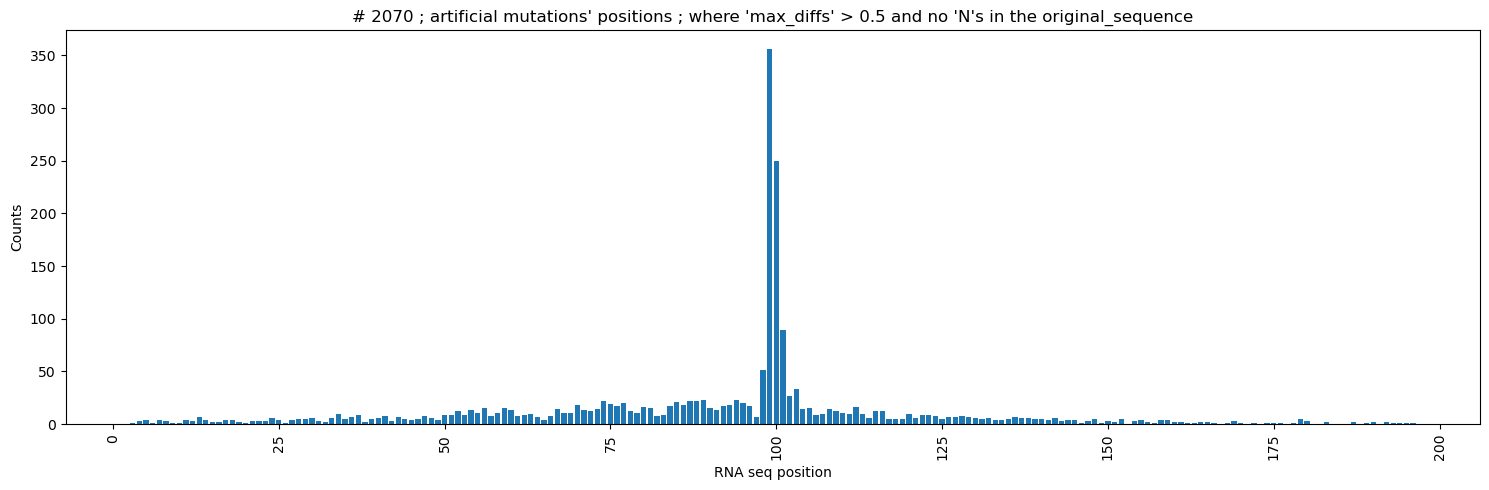

In [64]:
print("# "+ str(len(diff_positions)) +" ; artificial mutations' positions ; where 'max_diffs' > 0.5 and no 'N's in the original_sequence")

top_diff_sequences = high_diff_sorted_result_df[['original_sequence', 'max_diff_seqs']]
couple_diff_sequences = [(x, y) for x, y in top_diff_sequences.values]
diff_positions = [diff_index(*x) for x in couple_diff_sequences]

plot_diff_positions(diff_positions, plot_name = "# "+ str(len(diff_positions)) +" ; artificial mutations' positions ; where 'max_diffs' > 0.5 and no 'N's in the original_sequence")

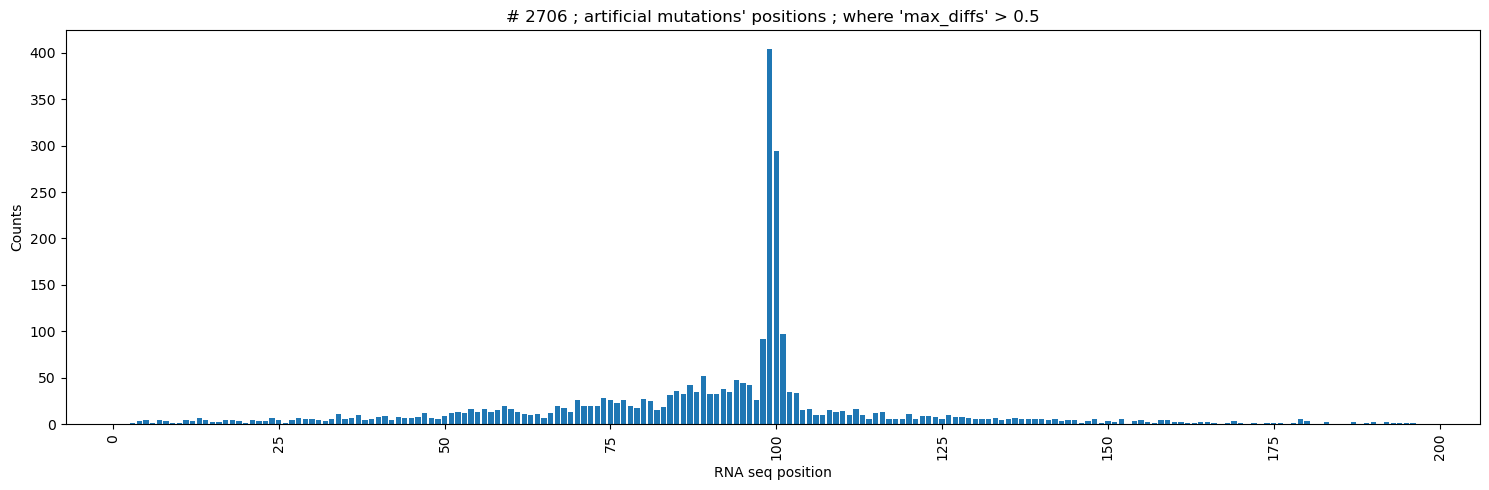

In [65]:
filtered_df = sorted_result_df[(sorted_result_df['max_diffs'] > 0.5)][['original_sequence', 'max_diff_seqs']]
couple_diff_sequences = [(x, y) for x, y in filtered_df.values]
diff_positions = [diff_index(*x) for x in couple_diff_sequences]

plot_diff_positions(diff_positions, plot_name = "# "+ str(len(diff_positions)) +" ; artificial mutations' positions ; where 'max_diffs' > 0.5")

In [ ]:
filtered_df = sorted_result_df[(sorted_result_df['max_diffs'] > 0.25)][['original_sequence', 'max_diff_seqs']]
couple_diff_sequences = [(x, y) for x, y in filtered_df.values]
diff_positions = [diff_index(*x) for x in couple_diff_sequences]

plot_diff_positions(diff_positions, plot_name = "# "+ str(len(diff_positions)) +" ; artificial mutations' positions ; where 'max_diffs' > 0.25")

In [60]:
filtered_df

,original_sequence,max_diff_seqs
325,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
322,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
324,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
323,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
216,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
...,...,...
30158,GGAAACCATTGTGCAGCTGGAGCGGGAGCTGGAGCGGCTGACCAAT...,GGAAACCATTGTGCAGCTGGAGCGGGAGCTGGAGCGGCTGACCAAT...
7931,TTTCAGGTATTTCTAGAATTGTGCTTCCTACAGAAAAAACTACAGG...,TTTCAGGTATTTCTAGAATTGTGCTTCCTACAGAAAAAACTACAGG...
19603,AGTGATCAACTTCCTTCAGAATTTATTAAGATTTCTAAAGTGAAAA...,AGTGATCAACTTCCTTCAGAATTTATTAAGATTTCTAAAGTGAAAA...
12139,CAATCTTGCAGGAGAGAGAGTTACTGCCTGTGAAGAAATTTGAAAG...,CAATCTTGCAGGAGAGAGAGTTACTGCCTGTGAAGAAATTTGAAAG...


In [ ]:
# (sorted_result_df['original_seq_pred'] > 0.5) & (sorted_result_df['min'] < 0.5)

filtered_df = sorted_result_df[
    (sorted_result_df['original_seq_pred'] > 0.5) & (sorted_result_df['min'] < 0.5)
][['original_sequence', 'max_diff_seqs']]
filtered_df
couple_diff_sequences = [(x, y) for x, y in filtered_df.values]
diff_positions = [diff_index(*x) for x in couple_diff_sequences]

plot_diff_positions(diff_positions, plot_name = "# "+ str(len(diff_positions)) +" ; artificial mutations' positions ; where pos to neg")

In [ ]:
# (sorted_result_df['original_seq_pred'] > 0.5) & (sorted_result_df['max'] > 0.5)

filtered_df = sorted_result_df[
    (sorted_result_df['original_seq_pred'] < 0.5) & (sorted_result_df['max'] > 0.5)
][['original_sequence', 'max_diff_seqs']]
filtered_df
couple_diff_sequences = [(x, y) for x, y in filtered_df.values]
diff_positions = [diff_index(*x) for x in couple_diff_sequences]

plot_diff_positions(diff_positions, plot_name = "# "+ str(len(diff_positions)) +" ; artificial mutations' positions ; where neg to pos)